# Problem Description

*Quoted from https://www.geeksforgeeks.org/egg-dropping-puzzle-dp-11/*

Suppose that we wish to know which stories in a 100-story building are safe to drop eggs from, and which will cause the eggs to break on landing. We make a few assumptions:

* An egg that survives a fall can be used again.
* A broken egg must be discarded.
* The effect of a fall is the same for all eggs.
* If an egg breaks when dropped, then it would break if dropped from a higher floor.
* If an egg survives a fall then it would survive a shorter fall.
* It is not ruled out that the first-floor windows break eggs, nor is it ruled out that the 36th-floor do not cause an egg to break.

If only one egg is available and we wish to be sure of obtaining the right result, the experiment can be carried out in only one way. Drop the egg from the first-floor window; if it survives, drop it from the second floor window. Continue upward until it breaks. In the worst case, this method may require 36 droppings. Suppose 2 eggs are available. What is the least number of egg-droppings that is guaranteed to work in all cases?

The problem is not actually to find the critical floor, but merely to decide floors from which eggs should be dropped so that total number of trials are minimized.

# Solution (Ideas)

Suppose you throw egg1 at floor $x$ and it is broken, then you have to use egg2 to try from floor $1, 2, ...$ until the critical floor where egg breaks again. Therefore for worst case scenario, the maximum steps $(x - 1)$ are required for second egg.

Considered another scenario where you throw egg1 at floor $x$ and it is not broken, the critical floor must be somewhere higher than $x$, basically this reduce the original problem to a egg dropping subproblem where we have 2 eggs and the floor levels are: 

<center>$x, x + 1, x + 2, ..., 100$ </center>

by subtracting x from every term yields

<center>$0, 1, 2, ...., 100 - x$</center>

This has reduced the problem to 2 eggs dropping problem for building with $(100 - x)$ floors.

# Solution (With mathematical notations)

Define $S(n, x)$ be the statement of 2 eggs dropping with $n$ floors building that can be solved with $x$ steps. Our goal is to find minimum $x$ that satisfies $S(100, x)$.

Suppose we throw egg1 at $x$-th floor of building with 100 floors, 
* If broken, require $(x-1)$ more steps to find the critical floor with egg2. Total steps = $x$.
* If not broken, we continue to solve the subproblem $S(100-x, x-1)$ with 2 unbroken eggs.

Hence we have property $S(100, x) \iff S(100-x, x-1)$. Furthermore, we can reduce the second parameter as following:

$S(100, x)$  
$ \iff S(100 - x, x - 1)$  
$ \iff S(100 - x - (x - 1), x - 2)$  
$ \iff S(100 - x - (x - 1) - (x - 2), x - 3)$  
$...$  
$ \iff S(100-(1 + 2 + 3 + ... + x)), 0) = S(100-x(x+1)/2, 0)$

Since the problem is solvable with no steps for number of floors $100-x(x+1)/2$, therefore this cannot be positive value. This is equivalent to find smallest $x$ where $x(x+1) >= 200$, $x = 14$ is the minimum steps to locate the critical floor.

#  Solution (Programming)
Perform simulation with 100,000 trials with random critical floor (randomness is determined by uniform distribution $U(1, 100)$). Compare the number of steps required for different strategies:

* Best Strategy - Follow approach approach by taking $14, 14+13, 14+13+12, ...$ as checkpoints.
* Naive Strategy - The safest and laziest way, simply try from the lowest floor and going upward.
* Blind Guess Strategy - Depends on luck, try on random floor, solving subproblems to reduce the search range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
checkpoints = np.arange(14, 0, -1).cumsum()
checkpoints = checkpoints[checkpoints <= 100]
while checkpoints[-1] < 100:
    checkpoints = np.append(checkpoints, checkpoints[-1] + 1)
    
def is_egg_broken(current_floor, critical_floor):
    return current_floor >= critical_floor

def throw_egg(current_floor, attempted_floors):
    attempted_floors.append(current_floor)

def best_strategy(critical_floor):
    attempted_floors = []
    for index, current_checkpoint in enumerate(checkpoints):
        if index > 0:
            last_checkpoint = checkpoints[index - 1]
        else:
            last_checkpoint = 0

        throw_egg(current_checkpoint, attempted_floors)
        if not is_egg_broken(current_checkpoint, critical_floor): continue

        backward_floors = range(last_checkpoint + 1, current_checkpoint)

        if len(backward_floors) == 0: continue

        for current_floor in backward_floors:
            throw_egg(current_floor, attempted_floors)
            if is_egg_broken(current_floor, critical_floor):
                break
        break
    return attempted_floors

def naive_strategy(critical_floor):
    attempted_floors = []
    first_floor = np.random.randint(1, 101)
    for current_floor in range(1, 101):
        throw_egg(current_floor, attempted_floors)
        if is_egg_broken(current_floor, critical_floor):
            break
    return attempted_floors

def blind_guess_strategy(critical_floor):
    attempted_floors = []
    
    current_start = 1
    current_end = 100
    is_found = False
    
    while(not is_found):    
        current_floor = np.random.randint(current_start, current_end + 1)
        throw_egg(current_floor, attempted_floors)
        if is_egg_broken(current_floor, critical_floor):
            for current_floor in range(current_start, current_floor):
                throw_egg(current_floor, attempted_floors)
                if is_egg_broken(current_floor, critical_floor):
                    is_found = True
                    break
            is_found = True
        else:
            current_start = current_floor + 1 
    
    return attempted_floors

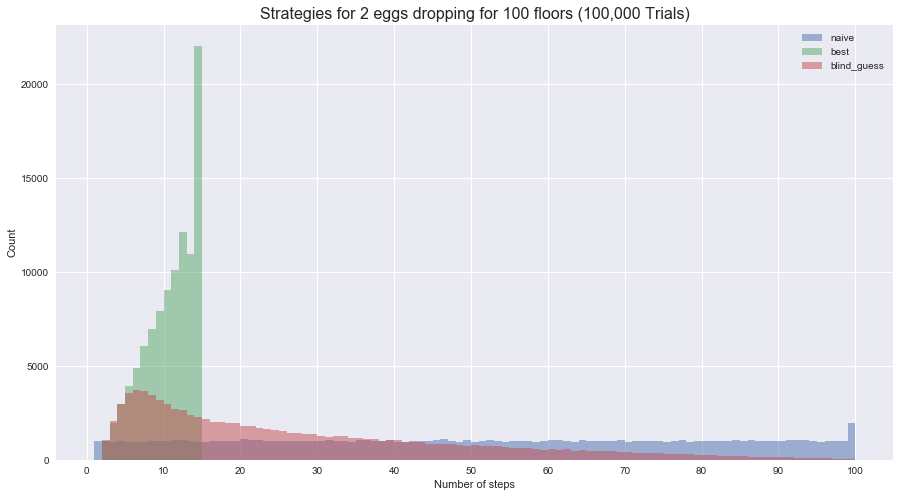

In [3]:
total = 100000
critical_floors = np.random.randint(1, 101, size=total)
result = []

for critical_floor in critical_floors:
    steps_naive = naive_strategy(critical_floor)
    steps_best = best_strategy(critical_floor)
    steps_blindguess = blind_guess_strategy(critical_floor)
    result.append({
        'critical_floor': critical_floor,
        'naive': len(steps_naive),
        'best': len(steps_best),
        'blind_guess': len(steps_blindguess)
    })

trials = pd.DataFrame(result)

fig, ax = plt.subplots(figsize=(15, 8))

columns = ['naive', 'best', 'blind_guess']
trials[columns].plot.hist(ax=ax, alpha=0.5, bins=range(1, 101))
ax.set_xticks(np.arange(0, 105, 10))
ax.set_title('Strategies for 2 eggs dropping for 100 floors ({:,} Trials)'.format(total), fontsize=16)
ax.set_ylabel('Count')
ax.set_xlabel('Number of steps')

plt.show()